# PART 1: Getting Authors and Titles from Tabula-exported TSV Data

The object: go from a list of tsv filenames (maybe I'll bin them by year?) to an array of [date, rank, weeks on list, title, author(s)]


In [1]:
import xml.etree.ElementTree
import urllib2
import re, string

f_filen = "tabula-1963-03-17.tsv"
nf_filen = "tabula-1963-03-17-nf.tsv"
#How far into the tsv file the data shows up...
data_i = 2
fields = ['rank','title+author','rank_last_week','weeks_on_list']

import csv
from datetime import datetime

def empty(row):
    for r in row:
        if r!="":
            return False
    return True 

def extract_date(datestr):
    print datestr
    date = datetime.strptime(datestr[0],'%B %d, %Y')
    print date
    return date

##Indexes into row data_i of a tsv and then reads it into an array of arrays
def read_tsv(name):
    i = 0
    arr = []
    date = ""
    with open(name) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for row in reader:
            if i ==0 :
                date = extract_date([row[1]])
            if ((i > data_i) & (not empty(row))):
                arr.append([date]+row)
            i = i+1
        return arr
    
commasv = read_tsv(nf_filen)
print commasv

['March 17, 1963']
1963-03-17 00:00:00
[[datetime.datetime(1963, 3, 17, 0, 0), '1', 'TRAVELS WITH CHARLEY, by John Steinbeck.', '1', '32'], [datetime.datetime(1963, 3, 17, 0, 0), '2', 'HAPPINESS IS A WARM PUPPY, by Charles M. Schulz.', '2', '13'], [datetime.datetime(1963, 3, 17, 0, 0), '3', 'FINAL VERDICT, by Adela Rogers St. Johns.', '4', '27'], [datetime.datetime(1963, 3, 17, 0, 0), '4', 'THE WHOLE TRUTH AND NOTHING BUT, by Hedda Hopper.', '7', '2'], [datetime.datetime(1963, 3, 17, 0, 0), '5', 'O YE JIGS & JULEPS!, by Virginia Cary Hudson.', '3', '43'], [datetime.datetime(1963, 3, 17, 0, 0), '6', 'THE FIRE NEXT TIME, by James Baldwin', '6', '3'], [datetime.datetime(1963, 3, 17, 0, 0), '7', 'SILENT SPRING, by Rachel Carson.', '5', '24'], [datetime.datetime(1963, 3, 17, 0, 0), '8', 'MY LIFE IN COURT, by Louis Nizer.', '10', '68'], [datetime.datetime(1963, 3, 17, 0, 0), '9', 'POINTS OF MY COMPASS, by E.B. White.', '8', '5'], [datetime.datetime(1963, 3, 17, 0, 0), '10', 'THE FALL OF THE 

In [2]:
import os

def read_folder(folderpath):
    empty_array = []
    for f in os.listdir(folderpath):
        commasv = read_tsv(path+f)
        empty_array.append(commasv)
    return empty_array

path = "1963/fiction/"
sixtythree = read_folder(path)

['March 17, 1963']
1963-03-17 00:00:00
['May 12, 1963']
1963-05-12 00:00:00
['March 31, 1963']
1963-03-31 00:00:00
['May 5, 1963']
1963-05-05 00:00:00
['May 26, 1963']
1963-05-26 00:00:00
['March 24, 1963']
1963-03-24 00:00:00
['April 7, 1963']
1963-04-07 00:00:00
['April 14, 1963']
1963-04-14 00:00:00
['April 28, 1963']
1963-04-28 00:00:00
['May 19, 1963']
1963-05-19 00:00:00
['April 21, 1963']
1963-04-21 00:00:00


In [3]:
manual_titles = []
manual_genders = []
done_dict = {}
viaf_dict={}
gender_dict={}

In [53]:
ta_to_data = {}

In [232]:
#print sixtythree[4]

def batch_process_lists(list_of_lists):
    batch_target = []
    for ls in list_of_lists:
        batch_target = batch_target + process(ls)
    print ("BATCHED 1963!!!")
    for x in batch_target:
        print x
    return batch_target    


# outputs data as a table form:
# date, year, ranks, title, authors, isbns, gender, categories, subjects, holdings

def process(ls):
    target = []
    for row in ls:
        date = row[0]
        ranks = {"this_week":row[1],"last_week":row[3],"weeks_on_list":row[4]}
        ta_tuple = title_author_pair(row[2])
        title = ta_tuple[0]
        authors = ta_tuple[1]
        new_row = [date,date.year,ranks,title,authors]
        if str(ta_tuple) in ta_to_data:
            data = ta_to_data[str(ta_tuple)]
            new_row = new_row+data
        else:
            isbns = get_isbns(title,authors)
            data = [isbns]
            if len(isbns)>0:
                o_data = oclc_process(isbns,authors)
                gender = o_data['genders']
                categories = o_data['categories']
                subjects = o_data['subjects']
                data = data + [gender,categories,subjects] 
                new_row = new_row + data
            ta_to_data[str(ta_tuple)] = data
        target.append(new_row)
    return target

batch = batch_process_lists(sixtythree)

BATCHED 1963!!!
[datetime.datetime(1963, 3, 17, 0, 0), 1963, {'this_week': '1', 'weeks_on_list': '5', 'last_week': '1'}, 'RAISE HIGH THE ROOF BEAM,  CARPENTERS', ['J.D. Salinger'], set(['0553125540', '0316769517', '055320596X', '0141049243', '0140237518', '0140022643']), [u'Male'], [{'percent': '46.854305', 'label': '813.5'}, {'percent': '23.075333', 'label': '813.54'}, {'percent': '14.072847', 'label': '813'}, {'percent': '0.39321193', 'label': 'FIC'}, {'percent': '0.020695364', 'label': '833 / 823.91'}, {'percent': '15.562914', 'label': 'Unclassified'}, {'percent': '0.020695364', 'label': 'Other'}], [{'fast_id': '807048', 'subject': 'American fiction'}, {'fast_id': '1728849', 'subject': 'Families'}, {'fast_id': '1173328', 'subject': 'Weddings'}, {'fast_id': '1007815', 'subject': 'Manners and customs'}, {'fast_id': '1125233', 'subject': 'Soldiers'}, {'fast_id': '1204155', 'subject': 'United States'}, {'fast_id': '839665', 'subject': 'Brothers'}, {'fast_id': '218522', 'subject': 'Glass

110
37
         date                                                ddc
0  1963-03-17  [{u'percent': u'46.854305', u'label': u'813.5'...
1  1963-03-17  [{u'percent': u'82.28571', u'label': u'813'}, ...
2  1963-03-17  [{u'percent': u'93.304535', u'label': u'813.54...
3  1963-03-17  [{u'percent': u'74.0531', u'label': u'FIC'}, {...
4  1963-03-17  [{u'percent': u'36.57652', u'label': u'823.9'}...
5  1963-03-17                                               None
6  1963-03-17  [{u'percent': u'91.62907', u'label': u'813.54'...
7  1963-03-17  [{u'percent': u'49.43662', u'label': u'FIC'}, ...
8  1963-03-17  [{u'percent': u'53.033268', u'label': u'813.54...
9  1963-03-17  [{u'percent': u'22.891565', u'label': u'813.54...
10 1963-05-12  [{u'percent': u'46.854305', u'label': u'813.5'...
11 1963-05-12  [{u'percent': u'82.28571', u'label': u'813'}, ...
12 1963-05-12  [{u'percent': u'70.82758', u'label': u'823.91'...
13 1963-05-12  [{u'percent': u'93.304535', u'label': u'813.54...
14 1963-05-12  [{u

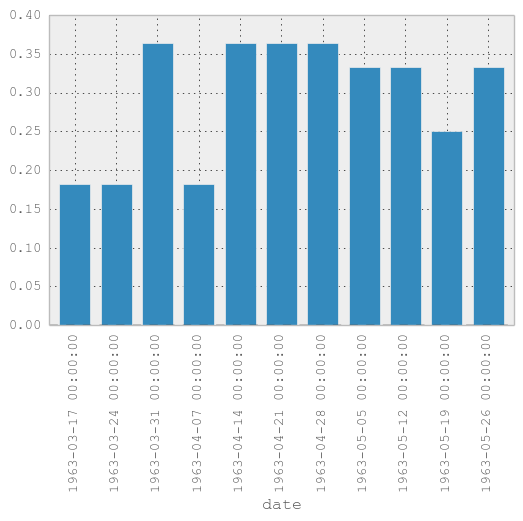

In [245]:
print len(batch)
%matplotlib inline
import pandas as pd
import matplotlib
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier

sixtythree_df = pd.DataFrame(batch,columns=["date","year","ranks","title","authors","isbns","genders","ddc","fast"])

sixtythree_series = sixtythree_df.set_index('date').genders

def count_females(arr):
    i = 0
    for x in arr:
        if x == "Female":
            i = i+1
    return i

i = 0
for x in sixtythree_df['genders']:
    if x is not None:
        i = i + count_females(x)
print i

grouped2 = sixtythree_df[["date","genders"]]

grouped = sixtythree_df["genders"].groupby(sixtythree_df["date"])


def bin_dates_percent_female(df,group_col):
    grouped = df["genders"].groupby(df[group_col])
    target = []
    for group in grouped:
        females = 0
        overall_count = 0
        date = group[0]
        for genders in group[1]:
            if genders is not None:
                females = females+count_females(genders)
                for g in genders:
                    overall_count = overall_count+1
        percent = float(females)/float(overall_count)
        target.append([date,percent,overall_count])
    return target
        
percent_female_table = bin_dates_percent_female(sixtythree_df,"date")

df = pd.DataFrame(percent_female_table,columns=["date","percent_female","number_of_authors"])
df = df.set_index("date")

df["percent_female"].plot(kind="bar")

#grouped = sixtythree_series.groupby(level=0)

#for x in grouped:
#    for y in x:
#        print "Printing y"
#        if 'series' in str(type(y)):
#            print y

In [286]:
grouped3 = sixtythree_df["ddc"].groupby(sixtythree_df["date"])
for x in grouped3:
    if x is not None:
        print "Printing date"
        for y in x[1]:
            "Printing y!"
            print y

## Add up all the percents and labels within a date, divide each aggregated "percent" by 100 * the number of books
def summarize_ddc(ls_label_dict):
    for label in ls_label_dict:
        label['percent']

Printing date
[{'percent': '46.854305', 'label': '813.5'}, {'percent': '23.075333', 'label': '813.54'}, {'percent': '14.072847', 'label': '813'}, {'percent': '0.39321193', 'label': 'FIC'}, {'percent': '0.020695364', 'label': '833 / 823.91'}, {'percent': '15.562914', 'label': 'Unclassified'}, {'percent': '0.020695364', 'label': 'Other'}]
[{'percent': '82.28571', 'label': '813'}, {'percent': '11.428572', 'label': '813.54'}, {'percent': '4.087912', 'label': 'FIC'}, {'percent': '0.74725276', 'label': '823.91'}, {'percent': '0.21978024', 'label': '823.914'}, {'percent': '0.043956045', 'label': '813.4 / 823'}, {'percent': '4.879121', 'label': 'Unclassified'}]
[{'percent': '93.304535', 'label': '813.54'}, {'percent': '0.6047516', 'label': '823.91'}, {'percent': '0.25917926', 'label': '791'}, {'percent': '0.043196544', 'label': 'FIC / 813.5'}, {'percent': '5.7451406', 'label': 'Unclassified'}, {'percent': '0.043196544', 'label': 'Other'}]
[{'percent': '74.0531', 'label': 'FIC'}, {'percent': '1

In [258]:
oclc_base = "http://classify.oclc.org/classify2/Classify?"
gender_dict = {}
test_isbns = ['0706610520', '3464127788', '0905712412', '067717604X', '0194216640', '0060502959', '0340013613', '0194230392']
test_authors = ['Mary Stewart']


# Returns an array of dicts format {'isbn':isbn,'oclc_id':oclc_i,'subjects'
# :subjects,'categories':categories,'genders':genders} if array lenghth > 1
# use sum_oclc to resolve/synthesize
def oclc_process(isbn_ls,authors):
    print isbn_ls
    print authors
    target = []
    done = []
    for isbn in isbn_ls:
        oclc_data = get_oclc_data(isbn)
        if (oclc_data['oclc_id'] not in done) and (oclc_data['holdings']!=0): 
            oclc_id = oclc_data['oclc_id']
            holdings = oclc_data['holdings']
            subjects = oclc_data['subjects']
            categories = oclc_data['ddc']
            genders = extract_gender(oclc_data['authors'],authors) 
            #Could turn this into an umbrella VIAF function, that returns genders and birth year
            row = {'isbn':isbn,'oclc_id':oclc_id,'subjects':subjects,'categories':categories,'genders':genders, 'holdings':holdings}
            done.append(oclc_id)
            target.append(row)
    if len(target)>1:
        print "Summarizing!"
        for row in target:
            print row
        target = summarize_oarr(target)
        print target
    return target[0]

# Go through an array of dicts, sorted by the number of holdings if the top holding has a blank value for a key,
# EEEK maybe use a while loop???
def summarize_oarr(oarr):
    sorted_target = sorted(oarr, key=lambda k: k['holdings'],reverse = True)
    target = {}
    for k in sorted_target[0].keys():
        i = 0 
        while True:
            if i == (len(oarr)-1):
                break
            item = sorted_target[i][k]
            if item != "" or item != 0 or item != []:
                target[k] = item
                break
            else:
                i = i+1
        if k not in target:
            target[k] = oarr[0][k]
    target["summarized_tag"] = 1
    return [target]

def max_holding(oarr):
    target = {}
    previous = oarr[0]
    for o in oarr:
        if o['holdings']>previous['holdings']:
            target = o
        previous = o
    return target
        
def url_to_x(url):
    req = urllib2.Request(url)
    req.add_header('User-agent', 'Mozilla 5.10')
    res = urllib2.urlopen(req)
    print res
    data = xml.etree.ElementTree.parse(res).getroot()
    return data
        
def extract_gender(oclc_a,author_ls):
    genders = []
    for a in author_ls:
        if a in gender_dict:
            genders.append(gender_dict[a])
        else:
            viaf_id = get_viaf_id(oclc_a,a)
            if viaf_id != "":
                viaf_dict[a] = viaf_id
                gender = get_gender_scrape(viaf_id)
                if gender != "":
                    gender_dict[a] = gender
                genders.append(gender)
    return genders
            
# Should I go into the VIAF and try to match the various labels?
def get_viaf_id(oclc_a_list,author):
    if author in viaf_dict:
        return viaf_dict[author]
    candidate = ""
    viaf = ""
    for b in oclc_a_list:
        if last_name(author) in b['name']:
            candidate = b['viaf']
            print first_name(author)
            if first_name(author) in b['name']:
                viaf = candidate
    if viaf == "":
        viaf = candidate
    return viaf

print oclc_process(test_isbns,test_authors)

['0706610520', '3464127788', '0905712412', '067717604X', '0194216640', '0060502959', '0340013613', '0194230392']
['Mary Stewart']
<addinfourl at 139826065962336 whose fp = <socket._fileobject object at 0x7f2bd0dcbdd0>>
<class 'xml.etree.ElementTree.Element'>
<class 'xml.etree.ElementTree.Element'>
['823.9', '823.914', 'FIC', '823.91', '428.6', '823', 'Unclassified']
http://www.viaf.org/viaf/109491991/
Female
<addinfourl at 139825708321608 whose fp = <socket._fileobject object at 0x7f2bb5f4f6d0>>
<class 'xml.etree.ElementTree.Element'>
<class 'xml.etree.ElementTree.Element'>
<addinfourl at 139825708321680 whose fp = <socket._fileobject object at 0x7f2bb5f4f950>>
<class 'xml.etree.ElementTree.Element'>
<class 'xml.etree.ElementTree.Element'>
['823.914', 'Unclassified']
<addinfourl at 139825708322112 whose fp = <socket._fileobject object at 0x7f2bb5f4fcd0>>
<class 'xml.etree.ElementTree.Element'>
<class 'xml.etree.ElementTree.Element'>
<addinfourl at 139825708340072 whose fp = <socket._fi

In [7]:

def get_oclc_data(isbn):
    url = oclc_base +"isbn="+isbn
    xml = url_to_x(url)
    print type(xml)
    authors = extract_authors(xml) #returns a list of dicts of form {'name':'author_name','viaf':'viaf_id'}
    print type(xml)
    subjects = extract_subjects(xml) #returns a list of dicts of form {'subject':'subject_name','fast_id':'fast_id'}
    ddc = extract_ddc(xml) #returns a list of dicts of form {'label':'ddc_label', 'percent':'percent_of_entries_w_label'}
    oclc_id = extract_oid(xml)
    holdings = extract_holdings(xml)
    return {'authors':authors,'subjects':subjects,'ddc':ddc,'oclc_id':oclc_id,'holdings':holdings}

def extract_oid(oclc):
    work = oclc.find('{http://classify.oclc.org}work')
    oid = ""
    if work is not None:
        oid = work.get('owi')
    return oid

def extract_holdings(oclc):
    work = oclc.find('{http://classify.oclc.org}work')
    holdings = 0
    if work is not None:
        holdings = work.get('holdings')
    return holdings

def extract_authors(oclc):
    oclc_a = oclc.find('{http://classify.oclc.org}authors')
    author_arr = []
    if oclc_a is not None:
        for author in oclc_a:
            author_arr.append({"name":author.text,"viaf":author.get("viaf")})
    return author_arr

def extract_subjects(oclc):
    r = oclc.find('{http://classify.oclc.org}recommendations')
    subject_arr = []
    if r is not None:
        fast = r.find('{http://classify.oclc.org}fast')
        if fast is not None:
            oclc_s = fast.find('{http://classify.oclc.org}headings')
            for subject in oclc_s:
                subject_arr.append({"subject":subject.text,"fast_id":subject.get("ident")})
            return subject_arr

def extract_ddc(oclc):
    r = oclc.find('{http://classify.oclc.org}recommendations')
    ddc_ls = []
    if r is not None:
        ddc_summary = r.find('{http://classify.oclc.org}ddc')
        if ddc_summary is not None:
            graph_url = ddc_summary.find('{http://classify.oclc.org}graph').text
            ddc_ls = parse_graph_url(graph_url)
    return ddc_ls

def get_percentages(url):
    nurl = url.split("chd=t:")
    nurl = nurl[1].split("&")
    parr = nurl[0].split(",")
    return parr

def get_labels(url):
    nurl = url.split("chdl=")
    larr = nurl[1].split("|")
    print larr
    return larr

def parse_graph_url(gurl):
    p = get_percentages(gurl)
    l = get_labels(gurl)
    target = []
    i = 0
    for label in l:
        target.append({"label":label,"percent":p[i]})
        i = i+1
    return target

data = get_oclc_data("0140024034")
print data


<addinfourl at 139826553309448 whose fp = <socket._fileobject object at 0x7f2be80891d0>>
<class 'xml.etree.ElementTree.Element'>
<class 'xml.etree.ElementTree.Element'>
['823.91', '823.912', '820', 'FIC', '823.3', 'Unclassified']
{'ddc': [{'percent': '70.82758', 'label': '823.91'}, {'percent': '21.310345', 'label': '823.912'}, {'percent': '0.5862069', 'label': '820'}, {'percent': '0.1724138', 'label': 'FIC'}, {'percent': '0.03448276', 'label': '823.3'}, {'percent': '7.0689654', 'label': 'Unclassified'}], 'holdings': '2873', 'subjects': [{'fast_id': '1204289', 'subject': 'France'}, {'fast_id': '1354514', 'subject': 'Revolution (France : 1789-1799)'}, {'fast_id': '943191', 'subject': 'Glass manufacture'}, {'fast_id': '19563', 'subject': 'Louis XVII, of France, 1785-1795'}], 'oclc_id': '20377499', 'authors': [{'viaf': '24600806', 'name': 'Du Maurier, Daphne, 1907-1989'}]}


In [306]:
sample_title_auth = commasv[0][2]
#print sample_title_authR

#index into phrase to skip " by"
auth_i = 4

def title_author_pair(data_str):
    split_str = data_str.split(',')
    title = ""
    auth_ph = ""
    authors = []
    i=0
    j=1
    for phrase in split_str:
        if i == 0:
            title = phrase
        else:
            if phrase.isupper():
                title = title + ", "+phrase
            else:
                auth_ph = auth_ph+phrase
        i = i+1
    end = len(auth_ph)
    parens = auth_ph.find("(")
    if parens != -1:
        end = parens-1
    auth_ph = auth_ph[auth_i:end]
    if " and " in auth_ph:
        author_arr = auth_ph.split(" and ")
        for author in author_arr:
            if author[len(author)-1]=='.':
                author = author[:len(author)-1] # strip trailing period
            authors.append(author)
    else:
        author = auth_ph
        if author[len(author)-1]=='.':
            author = author[:len(author)-1] # strip trailing period
        authors.append(author)
    return (title,authors)            
                
        
print title_author_pair(sample_title_auth)

('TRAVELS WITH CHARLEY', ['John Steinbeck'])


In [307]:
for row in commasv:
    print(title_author_pair(row[2]))

('TRAVELS WITH CHARLEY', ['John Steinbeck'])
('HAPPINESS IS A WARM PUPPY', ['Charles M. Schulz'])
('FINAL VERDICT', ['Adela Rogers St. Johns'])
('THE WHOLE TRUTH AND NOTHING BUT', ['Hedda Hopper'])
('O YE JIGS & JULEPS!', ['Virginia Cary Hudson'])
('THE FIRE NEXT TIME', ['James Baldwin'])
('SILENT SPRING', ['Rachel Carson'])
('MY LIFE IN COURT', ['Louis Nizer'])
('POINTS OF MY COMPASS', ['E.B. White'])
('THE FALL OF THE DYNASTIES', ['Edmond Taylor'])


# Data Collection and Storage

Store all data as we go through as a table (or look into pandas dataframe?). Each row is a BestSellers row and is formatted:

* date -- date
* title -- string
* author(s) -- arr[string]
* isbn_list -- arr[int]
* author_wiki_dat_id -- int
* author_gender(s) -- arr[string]

Maybe if there are too few ISBN matches for a book I should flag it for manual tagging? How few is too few? Will have to experiment.

Also want to store running dictionaries of these values so I don't need to call the function for the repeat appearances:

* {(Title,Author):[isbn_list, gender]}

# Getting ISBN from Title/Author Name


In [35]:
%run "key.py"

suffixes = ['CPA', 'CSC', 'CSJ', 'DC', 'DD', 'DDS', 'DMD', 'DO', 'DVM', 'EDD', 'ESQ', 'II', 'III', 
            'IV', 'INC', 'JD', 'JR', 'LLD', 'LTD', 'MD', 'OD', 'OSB', 'PC', 'PE', 'PHD', 'RET', 
            'RGS', 'RN', 'RNC', 'SHCJ', 'SJ', 'SNJM', 'SR', 'SSMO', 'USA', 'USAF', 'USAFR', 'USAR', 
            'USCG', 'USMC', 'USMCR', 'USN', 'USNR']

prefixes = []

digits = ['1','2','3','4','5','6','7','8','9','0']
symbol_dict = {'%':'percent','$':'dollar', '1/2':'half'}

isbn_plus_base_url = "https://api-2445581351187.apicast.io:443"
plus_key = isbn_plus_key
app_id = "7f7512d5"
search_plus = "/search?app_key="+plus_key+"&app_id="+app_id+"&t="
print isbn_plus_base_url+search_plus+"Potatoes"
alph = re.compile('[^a-zA-Z]')

db_key = isbn_db_key
isbn_db_base = "http://isbndb.com/api"
search_db = "/books.xml?access_key="+db_key+"&index1=title&value1="
print isbn_db_base+search_db+"Potatoes"

def convert_to_search(name):
    return_string = ""
    last_ch = " "
    for ch in name:
        if (ch == " "):
            if (last_ch != "."):
                return_string = return_string + "+"
        else:
            if ch == ".":
                return_string = return_string +".+"
            else:
                return_string = return_string+ch
        last_ch = ch
    return return_string

def url_to_xml(url):
    req = urllib2.Request(url)
    req.add_header('User-agent', 'Mozilla 5.10')
    res = urllib2.urlopen(req)
    print res
    data = xml.etree.ElementTree.parse(res).getroot()[0]
    for book in data.findall('BookData'):
        isbn = book.get('isbn')
        title = book.find('Title').text
        author = book.find('AuthorsText').text
        print(isbn,title,author)
    return data

def suffix(phrase):
    norm_phrase = phrase.replace(',',"").upper()
    if norm_phrase in suffixes:
        return True
    else:
        return False

def prefix(phrase):
    norm_phrase = phrase.replace(',',"").upper()
    if norm_phrase in prefixes:
        return True
    else:
        return False

    
def last_name_recursive(name,last_index):
    if last_index == 0:
        return ""
    last_phrase = name[last_index]
    if not suffix(last_phrase):
        return last_phrase
    else:
        return last_name_recursive(name, last_index-1)

def last_name(name):
    names = name.split(" ")
    last_index = len(names)-1
    last = last_name_recursive(names,last_index)
    return last

def first_name(name):
    names = name.split(" ")
    return names[0]

def strip_punct(text):
    return alph.sub('', text)

def has_numbers(text):
    for digit in digits:
        if digit in text:
            return True
    return False

def has_symbols(text):
    for symbol in symbol_dict:
        if symbol in text:
            return True
    return False

def norm_text(text):
    return strip_punct(text).lower()

def is_book(booxml, title, authors):
    xml_title = booxml.find('Title').text
    norm_xml_title = norm_text(xml_title)
    norm_title = norm_text(title)
    if(norm_xml_title in norm_title) or (norm_title in norm_xml_title):
        xml_authors = booxml.find('AuthorsText').text
        if xml_authors is None:
            return False
        for author in authors:
            if norm_text(author) in norm_text(xml_authors):
                print "Adding ISBN! "+xml_title+" by "+xml_authors
                return True
            xml_names = []
            for xmla in xml_authors.split(" "):
                norm_text(xmla)
            for author in authors:
                if norm_text(last_name(author)) in xml_authors.split(" "):
                    print xml_authors.split(" ")
                    print "Adding ISBN! "+xml_title+" by "+xml_authors
                    return True        
        return False

def get_isbns(title,authors):
    isbns = set()
    search_t = convert_to_search(title)
    url = isbn_db_base+search_db+search_t
#    print row[0].year
    data = url_to_xml(url)
    for book in data:
        if (is_book(book,title,authors)):
            isbns.add(book.get('isbn'))            
    return isbns

https://api-2445581351187.apicast.io:443/search?app_key=62f7cedf62afa7006026634aaadce211&app_id=7f7512d5&t=Potatoes
http://isbndb.com/api/books.xml?access_key=1DR9S9TA&index1=title&value1=Potatoes


In [8]:
print last_name('Charles W. Bailey II')

Bailey


In [16]:
def process_bs_list(best_sellers, year):
    target = []
    for row in best_sellers:
        title_author = title_author_pair(row[2])
        print str(title_author)
        isbns = []
        if has_symbols(title_author[0]) or has_numbers(title_author[0]):
            manual_titles.append(title_author)
        else:
            stritle_author = str(title_author)
            if stritle_author not in done_dict:
                isbns = get_isbns(title_author[0],title_author[1])
                if len(isbns) == 0:
                    manual_titles.append(title_author)
                done_dict[stritle_author] = isbns
            else:
                isbns = done_dict[stritle_author]
        target.append([year,title_author[0],title_author[1],isbns])
    return target
                
for x in process_bs_list(commasv,1963):
    print x

('TRAVELS WITH CHARLEY', ['John Steinbeck'])
<addinfourl at 139723408233032 whose fp = <socket._fileobject object at 0x7f13e429af50>>
('1405509163', 'Travels with Charley', None)
('043474011X', 'Travels with Charley', 'John Steinbeck')
('0783887914', 'Travels with Charley', 'John Steinbeck')
('0330201107', 'Travels with Charley', 'John Steinbeck')
('0808588761', 'Travels With Charley', None)
('0140053204', 'Travels with Charley', 'John Steinbeck')
('0142000701', 'Travels with Charley', 'John Steinbeck')
('1560773448', 'Travels With Charley', 'Judie Henson, Sheryl Lee Hinman, ')
('0788734822', 'Travels with Charley In Search of America', 'John Steinbeck, Ron McLarty (Narrator)')
('0141186100', 'Travels with Charley in search of America', 'John Steinbeck; with an introduction by Jay Parini')
Adding ISBN! Travels with Charley by John Steinbeck
Adding ISBN! Travels with Charley by John Steinbeck
Adding ISBN! Travels with Charley by John Steinbeck
Adding ISBN! Travels with Charley by John S

In [26]:
def process_bs_batch(batch):
    batch_target = []
    for ls in batch:
        process_bs_list(ls)


[('TRIUMPH', ['Philip Wylie'])]


# Getting Gender Data from Author Name

In [11]:
wiki_name_to_id = "https://www.wikidata.org/w/api.php?action=wbsearchentities&language=en&format=json&search="
wiki_id_to_data = "https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&props=claims&languages=en&ids="
gender_prop_id = "P21"
wiki_gender_hash = {"Q6581097":"male", "Q6581072":"female","Q1052281":"transf","Q2449503":"transm","Q1097630":"intersex"}

import urllib2
import json

def url_to_data( url ):
    req = urllib2.Request(url)
    req.add_header('User-agent', 'Mozilla 5.10')
    res = urllib2.urlopen(req)
    data = json.load(res)
    return data

def same_gender(id_list):
    id_0 = id_list[0]
    for i in id_list[1:]:
        if gender_from_id(id_0) != gender_from_id(i):
            return False
    return True

## This needs to disambiguate -- does it need to pull more information by id?
## Let's do it
def disambiguate(entity_data, name):
    entities = []
    for entity in entity_data:
        if 'description' in entity:
            desc = entity['description'].lower()
            ent_id = entity['id']
            if ('novel' in desc) or ('write' in desc) or ('auth' in desc) or ('cartoo' in desc) or ('journ' in desc) or ('comic' in desc):
                entities.append((ent_id,desc))
    if len(entities)==0:
        print "No novelists, writers, authors, cartoonists, journalists or comics named "+name
        manual_genders.add(name)
        for x in entity_data:
            print x
    return entities

def get_wiki_id(name):
    search_term = convert_to_search(name)
    url = wiki_name_to_id + search_term
    data = url_to_data(url)['search']
    if data == []:
        return [-1]
    dis_data = disambiguate(data,name)
    if dis_data == []:
        return [-1]
    i = []
    for entity in dis_data:
        i.append(entity[0])
    return i

def gender_from_id(auth_id):
    url = wiki_id_to_data + auth_id
    print url
    claims = url_to_data(url)['entities'][str(auth_id)]['claims']['P21']
    gender_arr =[]
    for claim in claims:
        if claim['mainsnak']['datavalue']['value'] is not None:
            gender_id = claim['mainsnak']['datavalue']['value']['id']
            gender_arr.append(wiki_gender_hash[gender_id])
    if len(gender_arr)>1:
        gender = max_value(gender_arr) ## FIX THIS
    else:
        gender = gender_arr[0]
    return gender


#def book_to_key_facts(book_data):

def author_to_gender(author_name):
    gender = ""
    author_id = []
    author_id = get_wiki_id(author_name)
    print author_id
    if author_id[0] == -1:
        print "Unable to find "+author_name+" in database"
        return "unknown"
    if len(author_id)>1:
        print "More than one writer by the name "+author_name
        if(same_gender(author_id)):
            gender = gender_from_id(author_id[0])
    else:
        gender = gender_from_id(author_id[0])
        return gender

# FUCK WIKIDATA, LIBRARIES GOT ME COVERED

Look up book genres by ISBN using this tool:

https://platform.worldcat.org/api-explorer/apis/Classify

classify.oclc.org/classify2/Classify?oclc=57358293&summary=true

I could also apparently use this to GET isbns -- I'll try it for a table and compare.

This returns authors per book with their names and VIAF id, which I can look up here:

https://platform.worldcat.org/api-explorer/apis/VIAF
https://platform.worldcat.org/api-explorer/apis/VIAF/AuthorityCluster/Identify


In [10]:
print author_to_gender("Virginia Cary Hudson")

[u'Q15637611']
https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&props=claims&languages=en&ids=Q15637611
female


In [54]:
for row in commasv:
    authors = title_author_pair(row[2])[1]
    for author in authors:
        gender = author_to_gender(author)
        print author + " was a "+gender

[u'Q39212', u'Q5559244']
More than one writer by the name John Steinbeck
https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&props=claims&languages=en&ids=Q39212
https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&props=claims&languages=en&ids=Q5559244
https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&props=claims&languages=en&ids=Q39212
John Steinbeck was a male
[u'Q298920']
https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&props=claims&languages=en&ids=Q298920
Charles M. Schulz was a male
[u'Q353774']
https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&props=claims&languages=en&ids=Q353774
Adela Rogers St. Johns was a female
No novelists, writers, authors, cartoonists, journalists or comics named Hedda Hopper
{u'pageid': 262584, u'description': u'Actress, gossip columnist, radio personality', u'title': u'Q271324', u'concepturi': u'http://www.wikidata.org/entity/Q271324', u'label': u'Hedda Hopper', u'u

# ISBNS & Author Name to Gender

Use the VIAF api https://platform.worldcat.org/api-explorer/apis/VIAF/AuthorityCluster/GetDataInFormat

# ISBNS to Subjects/Genres/DDC Category

Use the OCLC classify api -- much better than goodreads! http://classify.oclc.org/classify2/api_docs/

In [12]:
VIAF = {"Jane Austen":"102333412","James Tiptree":"266704950","Dan Brown":"102403515","J.K. Rowling":"116796842",
        "J.D. Salinger":"17092","Chimamanda":"87194517","Dostoyevski":"104023256", "Hedda Hopper":"52211425"}
headers= {"User-Agent":"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.82 Safari/537.36"}

import urllib2
import xml.etree.ElementTree
from lxml import html
from bs4 import BeautifulSoup
import requests

viaf_base = "http://www.viaf.org/viaf/"


def get_gender_scrape(i):
    url = viaf_base+str(i)+"/"
    print url
    data = requests.get(url).text
    soup = BeautifulSoup(data,"lxml")
    personal = soup.find('div',{'id':'personalinfo'})
    h4s = personal.find('h4')
    if len(h4s)<5:
        return ""
    #print type(h4s)
    mt = []
    i=0
    for h in h4s:
        mt.append(h)
        #print "element "+str(i)+": "+str(h)
        i = i+1
    print mt[4]
    return mt[4]

print get_gender_scrape(VIAF["Dan Brown"])

#tree = html.fromstring(page.content)
#print page.text
#tags =  tree.xpath("//*[@id='personalinfo']/h4/span[class='langHi0']")
#print tags


http://www.viaf.org/viaf/102403515/
Male
Male


In [25]:

for v in VIAF:
    print VIAF[v]
    print v+" is tagged as: "+str(get_gender_scrape(VIAF[v]))

102403515
http://www.viaf.org/viaf/102403515/
Male
Dan Brown is tagged as: Male
116796842
http://www.viaf.org/viaf/116796842/
Female
J.K. Rowling is tagged as: Female
266704950
http://www.viaf.org/viaf/266704950/
Female
James Tiptree is tagged as: Female
104023256
http://www.viaf.org/viaf/104023256/
Male
Dostoyevski is tagged as: Male
52211425
http://www.viaf.org/viaf/52211425/
Female
Hedda Hopper is tagged as: Female
102333412
http://www.viaf.org/viaf/102333412/
Jane Austen is tagged as: 
17092
http://www.viaf.org/viaf/17092/
Male
J.D. Salinger is tagged as: Male
87194517
http://www.viaf.org/viaf/87194517/
Female
Chimamanda is tagged as: Female
